# <b> <font color='blue'> <center> Training Visualization </center> </font> </b>

## Baseline

### Normalized data

ordenar por fechga

ver lkas ultimas 2 de cada modelo; realizar un mínimo análisis, por ej. relativo al overfitting;




In [22]:
import json
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# Path to runs_index.json
index_path = Path("../logs/training/baseline/simple/runs_index.json")

# Load runs_index.json
with open(index_path) as f:
    runs_index = json.load(f)

# Sort by timestamp
runs_index.sort(key=lambda x: x["timestamp"])

# Base directory for JSON files
base_dir = index_path.parent

# Group runs by model_name
models = defaultdict(list)
for run in runs_index:
    run_path = base_dir / run["json_file"]
    with open(run_path) as f:
        run_data = json.load(f)
    models[run_data["model_name"]].append(run_data)


# goal of the previous part -> order by date!!!!!

In [23]:
models['baseline'][0]['history']

{'accuracy': [0.660804033279419,
  0.660804033279419,
  0.6909547448158264,
  0.6783919334411621,
  0.733668327331543,
  0.7236180901527405,
  0.7512562870979309,
  0.7361809015274048,
  0.7688442468643188,
  0.7638190984725952],
 'loss': [6.762200355529785,
  5.433404922485352,
  4.535399436950684,
  4.299437999725342,
  3.92551851272583,
  3.6223130226135254,
  3.431886672973633,
  3.302238941192627,
  2.8782291412353516,
  2.8229711055755615],
 'precision': [0.5350000262260437,
  0.5339806079864502,
  0.5663265585899353,
  0.5483871102333069,
  0.6174863576889038,
  0.5979899764060974,
  0.6420454382896423,
  0.6037735939025879,
  0.6610169410705566,
  0.6395938992500305],
 'recall': [0.718120813369751,
  0.7382550239562988,
  0.744966447353363,
  0.7986577153205872,
  0.7583892345428467,
  0.7986577153205872,
  0.7583892345428467,
  0.8590604066848755,
  0.7852349281311035,
  0.8456375598907471],
 'val_accuracy': [0.6140350699424744,
  0.8421052694320679,
  0.7719298005104065,
  0.

In [24]:
import pandas as pd
from IPython.display import display

data = {
    'model_name': 'baseline',
    'data_variant': 'testing_purposes',
    'timestamp': '20250814_150158',
    'test_loss': 11.006034851074219,
    'test_accuracy': 0.2017543911933899,
    'hyperparameters': {
        'batch_size': 64,
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'epochs': 2
    }
}

# Separate basic info and hyperparameters
basic_info_keys = ['model_name', 'data_variant', 'timestamp', 'test_loss', 'test_accuracy']
basic_info = {k: data[k] for k in basic_info_keys}
hyperparams = data['hyperparameters']

# Convert to DataFrames
df_basic = pd.DataFrame([basic_info])
df_hyper = pd.DataFrame([hyperparams])

# Display nicely in notebook
print("=== Basic Info ===")
display(df_basic)

#print("=== Hyperparameters ===")
#display(df_hyper)

# Convert to vertical table
df_hyper_vertical = pd.DataFrame(list(hyperparams.items()), columns=['Parameter', 'Value'])

print("=== Hyperparameters (Vertical) ===")
display(df_hyper_vertical)

=== Basic Info ===


,model_name,data_variant,timestamp,test_loss,test_accuracy
0,baseline,testing_purposes,20250814_150158,11.006035,0.201754


=== Hyperparameters (Vertical) ===


,Parameter,Value
0,batch_size,64
1,optimizer,adam
2,learning_rate,0.001
3,epochs,2


In [25]:
models['baseline'][0]

{'model_name': 'baseline',
 'data_variant': 'simple',
 'timestamp': '20250819_160109',
 'hyperparameters': {'batch_size': 32,
  'optimizer': 'adam',
  'learning_rate': 0.0010000000474974513,
  'epochs': 10},
 'history': {'accuracy': [0.660804033279419,
   0.660804033279419,
   0.6909547448158264,
   0.6783919334411621,
   0.733668327331543,
   0.7236180901527405,
   0.7512562870979309,
   0.7361809015274048,
   0.7688442468643188,
   0.7638190984725952],
  'loss': [6.762200355529785,
   5.433404922485352,
   4.535399436950684,
   4.299437999725342,
   3.92551851272583,
   3.6223130226135254,
   3.431886672973633,
   3.302238941192627,
   2.8782291412353516,
   2.8229711055755615],
  'precision': [0.5350000262260437,
   0.5339806079864502,
   0.5663265585899353,
   0.5483871102333069,
   0.6174863576889038,
   0.5979899764060974,
   0.6420454382896423,
   0.6037735939025879,
   0.6610169410705566,
   0.6395938992500305],
  'recall': [0.718120813369751,
   0.7382550239562988,
   0.744966

{'accuracy': [0.660804033279419, 0.660804033279419, 0.6909547448158264, 0.6783919334411621, 0.733668327331543, 0.7236180901527405, 0.7512562870979309, 0.7361809015274048, 0.7688442468643188, 0.7638190984725952], 'loss': [6.762200355529785, 5.433404922485352, 4.535399436950684, 4.299437999725342, 3.92551851272583, 3.6223130226135254, 3.431886672973633, 3.302238941192627, 2.8782291412353516, 2.8229711055755615], 'precision': [0.5350000262260437, 0.5339806079864502, 0.5663265585899353, 0.5483871102333069, 0.6174863576889038, 0.5979899764060974, 0.6420454382896423, 0.6037735939025879, 0.6610169410705566, 0.6395938992500305], 'recall': [0.718120813369751, 0.7382550239562988, 0.744966447353363, 0.7986577153205872, 0.7583892345428467, 0.7986577153205872, 0.7583892345428467, 0.8590604066848755, 0.7852349281311035, 0.8456375598907471], 'val_accuracy': [0.6140350699424744, 0.8421052694320679, 0.7719298005104065, 0.8421052694320679, 0.8245614171028137, 0.859649121761322, 0.859649121761322, 0.8421

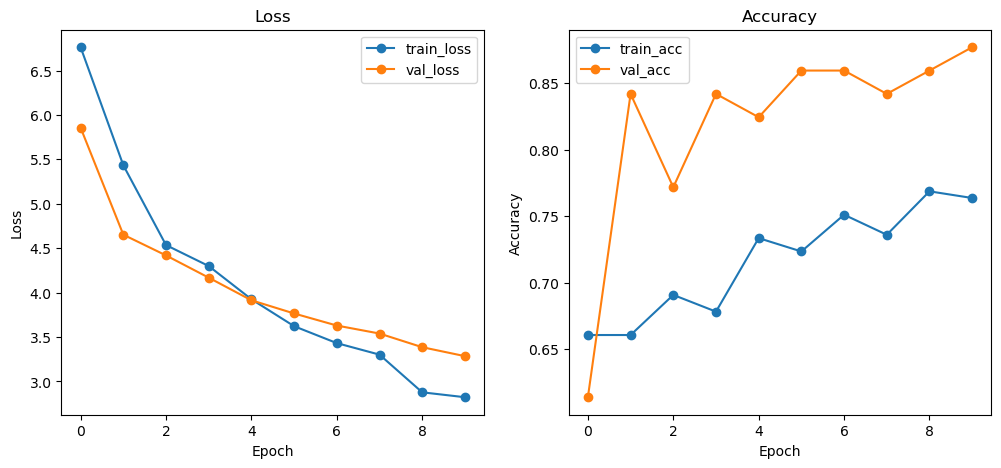

In [26]:
# with loss and acc
def plot_history(history):
    # Plot
    plt.figure(figsize=(12, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='train_loss', marker='o')
    plt.plot(history['val_loss'], label='val_loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='train_acc', marker='o')
    plt.plot(history['val_accuracy'], label='val_acc', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()
        

history = models['baseline'][0]['history']
print(history)
plot_history(history)

In [ ]:
#/home/marcos/Escritorio/AI-prod/ML-Prod-Example